# List 10
## D-separation

### Knowledge & Skills:

 - graphs
 - NetworkX usage
 - d-separation
 - interaction types
 
### Remarks
 - Do not repeat yourself, check if the implementation of one task is also the implementation of others,
 - Do not copy your code, create functions and reuse them
 - Use env that will help you solve problems not create new ones in given task
 - Graphical Models Principles and Techniques - p.69
 - [D-separation Article](https://www.andrew.cmu.edu/user/scheines/tutor/d-sep.html)
 - [You Tube Explanation](https://www.youtube.com/watch?v=aA-gTNxy1rw)
 - [Article - How to determine which variables are independent in a Bayes net.
](http://web.mit.edu/jmn/www/6.034/d-separation.pdf)

In [1]:
!pip install numpy networkx pandas
!pip install ndlib

In [39]:
import matplotlib.pyplot as plt
import networkx as nx
import ndlib.models.ModelConfig as mc
import numpy as np
from itertools import combinations
import pandas as pd
import time
import datetime

Exercise 1
============

**Prepare dependency graphs with their visualizations (random directed graphs).**

In [15]:
def plotGraph(G, grid_position = 111, title="", given = [], colorNodes = []):
    pos = nx.circular_layout(G)
    ax = plt.subplot(grid_position)
    ax.set_title(title)
    nx.draw(G, pos = pos,
            node_size=800, width=2,
            node_color='#000044', edge_color='#000099', font_color='w', font_size=10,
            with_labels=True)
    nx.draw_networkx_nodes(G, pos,
            nodelist=given, node_size=800, width=2,
            node_color='#888888', edge_color='#000099')
    nx.draw_networkx_nodes(G, pos,
            nodelist=colorNodes, node_size=800, width=2,
            node_color='#990000', edge_color='#000099')

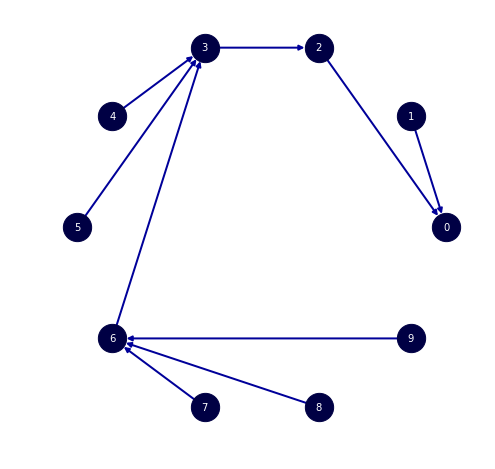

In [16]:
plt.figure(figsize=(8, 8))
G = nx.gn_graph(10)

plotGraph(G, 111)

Exercise 2
============

**Implements method that will show d-separability (tuple for each vertex with boolean infomation about d-separability) for given set of vertices Z.**

* Usefull link: [Article - How to determine which variables are independent in a Bayes net.
](http://web.mit.edu/jmn/www/6.034/d-separation.pdf)

In [17]:
def getSubgraph(G, nodes):
    s = set()
    nodes_to_check = nodes
    while len(nodes_to_check) > 0:
        node = nodes_to_check.pop()
        if (node not in s):
            s.add(node)
            nodes_to_check += G.predecessors(node)
    return G.subgraph(s)

def cartesian(x):
    y = np.transpose([np.tile(x, len(x)), np.repeat(x, len(x))])
    return np.array(list(filter(lambda x: x[0] != x[1], y)))

def moralize(G):
    newEdges = []
    for node in G.nodes:
        parents = list(G.predecessors(node))
        newEdges += cartesian(parents).tolist()
    H = G.copy()
    H.add_edges_from(newEdges)
    return H

def removeGivens(G, givens):
    H = G.copy()
    H.remove_nodes_from(givens)
    return H

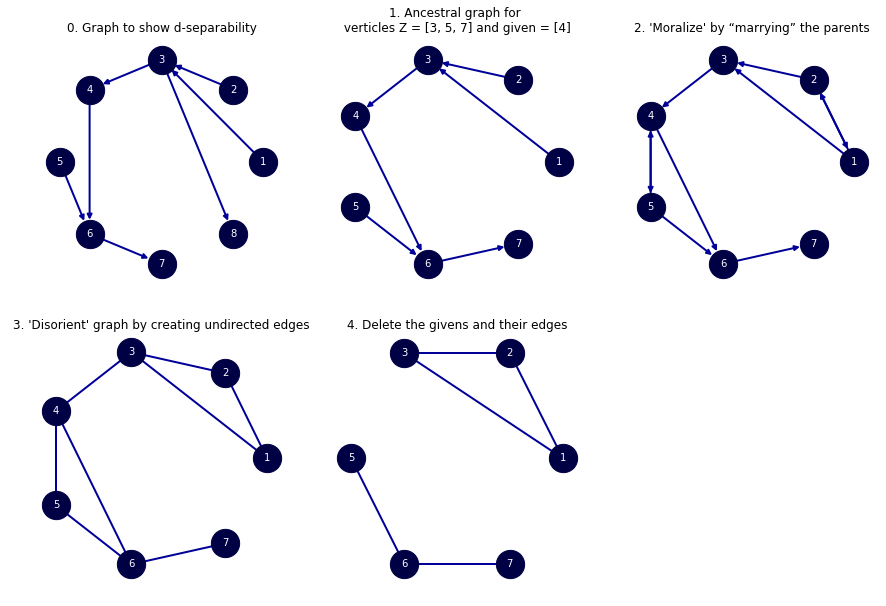

In [46]:
# Preparing graph to test
G = nx.DiGraph()
G.add_nodes_from(range(1, 9))
G.add_edges_from([(1,3),(2,3),(3,4),(3,8),(4,6),(5,6),(6,7)])
Z = [3, 5, 7]
given = [4]
print_z = str(Z)
print_given = str(given)


plt.figure(figsize=(15, 10))
plotGraph(G, 231, "0. Graph to show d-separability")

H1 = getSubgraph(G, Z)
plotGraph(H1, 232, "1. Ancestral graph for \n verticles Z = {} and given = {} ".format(print_z, print_given))

H2 = moralize(H1)
plotGraph(H2, 233, "2. 'Moralize' by “marrying” the parents")

H3 = H2.to_undirected()
plotGraph(H3, 234, "3. 'Disorient' graph by creating undirected edges")

H4 = removeGivens(H3, given)
plotGraph(H4, 235, "4. Delete the givens and their edges")

Exercise 3
============

**Execute d-separability method for random graphs, print vertices witch are d-separable.**

In [47]:
def isSeparable(G, start, end, given):
    ancestorsG = getSubgraph(G, [start, end, *given])
    moralizedG = moralize(ancestorsG)
    undirectedG = moralizedG.to_undirected()
    finalG = removeGivens(undirectedG, given)
    return not nx.has_path(finalG, start, end)

In [48]:
nodes = set(filter(lambda x: x not in given, G.nodes))

dSeparated = pd.DataFrame(columns=['Node A', 'Node B', 'Is Separated'])
for a, b in cartesian(list(nodes)):
    dS = isSeparable(G, b, a, given)
    dSeparated = dSeparated.append(pd.Series({ 'Node A': b, 'Node B': a, 'Is Separated': dS }), ignore_index=True)
dSeparated.set_index(['Node A', 'Node B'], inplace=True)

dSeparated.loc[dSeparated['Is Separated'] == True]


Is Separated
Node A Node B             
1      5              True
       6              True
       7              True
2      5              True
       6              True
       7              True
3      5              True
       6              True
       7              True
5      1              True
       2              True
       3              True
       8              True
6      1              True
       2              True
       3              True
       8              True
7      1              True
       2              True
       3              True
       8              True
8      5              True
       6              True
       7              True

In [49]:
dSepVertices = dSeparated.groupby('Node A').apply(lambda x: pd.Series([x.all()['Is Separated']]))
dSepVertices.loc[dSepVertices[0]]

dSepVertices.columns=["Is D-Separability"]
dSepVertices

,Is D-Separability
Node A,
1,False
2,False
3,False
5,False
6,False
7,False
8,False


Exercise 4
============

**Visualize graphs using d-separability information (different color of d-separable vertices).**

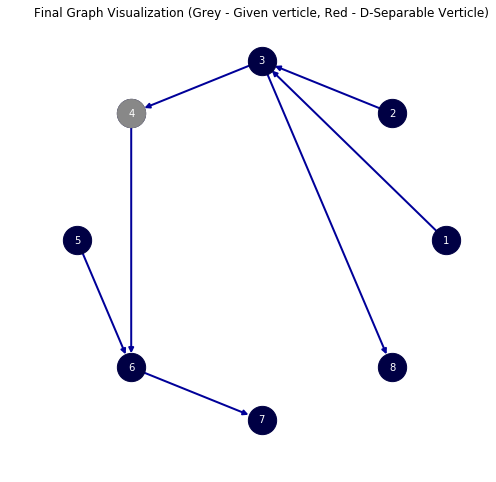

In [50]:
colorNodes = dSepVertices.loc[dSepVertices['Is D-Separability']].reset_index()['Node A'].tolist()
plt.figure(figsize=(8, 8))
plotGraph(G, 111, "Final Graph Visualization (Grey - Given verticle, Red - D-Separable Verticle)", given, colorNodes)

Exercise 5
============

**Using the loaded graph, take measurements of the speed of d-separability generation.**

In [57]:
def check_d_separation(G, given):
    nodes = set(filter(lambda x: x not in given, G.nodes))

    dSeparated = pd.DataFrame(columns=['Node A', 'Node B', 'Is Separated'])
    for a, b in cartesian(list(nodes)):
        dS = isSeparable(G, b, a, given)
        dSeparated = dSeparated.append(pd.Series({ 'Node A': b, 'Node B': a, 'Is Separated': dS }), ignore_index=True)
    dSeparated.set_index(['Node A', 'Node B'], inplace=True)

    return dSeparated

def make_measure(G, given):
    start = time.time()

    dSeparated = measure(G, [3, 5, 10, 20, 40, 12, 13, 14, 15])

    end = time.time()
    print("Given nodes number: {}".format(len(given)))
    print("Given nodes: {}".format(given))
    print("Measure result: {}\n".format(str(datetime.timedelta(seconds=(end - start)))))

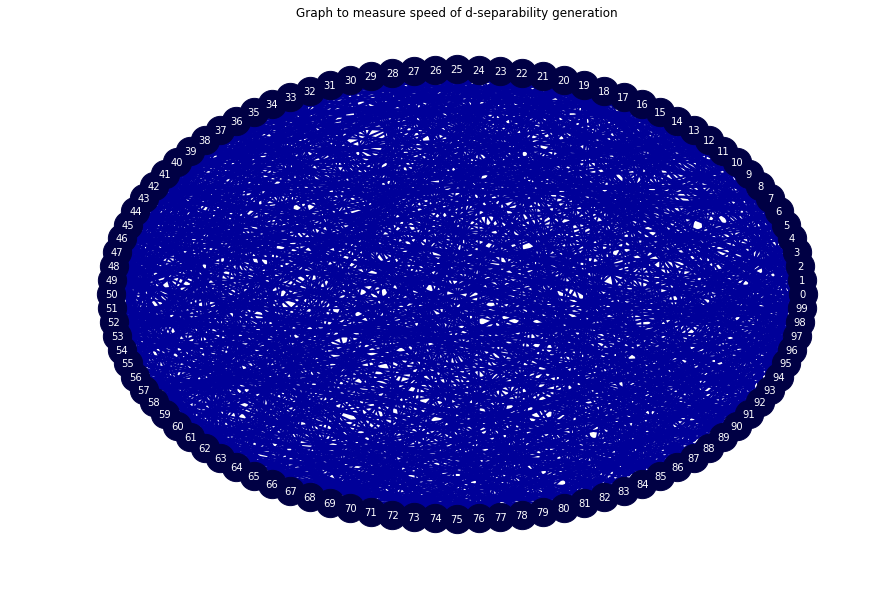

In [58]:
graph_path = "Data/Graph.txt"
Z = [3, 5, 7, 10, 12]

G=nx.read_adjlist(graph_path, create_using=nx.DiGraph(), nodetype=int)

plt.figure(figsize=(15, 10))
plotGraph(G, 111, "Graph to measure speed of d-separability generation")

In [59]:
make_measure(G, [3, 5])
make_mlocaeasure(G, [3, 5, 8])
make_measure(G, [3, 5, 8, 10, 12, 13, 9, 4, 6, 11])

Given nodes number: 2
Given nodes: [3, 5]
Measure result: 0:04:50.258821

Given nodes number: 3
Given nodes: [3, 5, 8]
Measure result: 0:04:37.674695

Given nodes number: 10
Given nodes: [3, 5, 8, 10, 12, 13, 9, 4, 6, 11]
Measure result: 0:05:04.165573

